In [1]:
import numpy
import pandas
from src.data_objects import AllData
from src.functions import *

retrain = True
runchain = True

model_par = "input/fullDesign.txt"
ThisData = AllData
outdir = "/data/rjfgroup/rjf01/cameron.parker/tunes/full/"

Trimming points and obs ranges

In [2]:
trimRanges(ThisData)

In [3]:
badpoints = []
trimPoints(badpoints,ThisData)

[[4.27714627 0.21524064 0.2563957  0.27981108 0.12534235 0.29716466]
 [3.18908704 0.47793064 0.67335541 0.37059415 0.11667519 0.34098795]
 [4.57858696 0.84776374 0.44139556 0.10164148 0.28353904 0.11007483]
 ...
 [1.9504744  0.53699904 0.70090248 0.20971928 0.17451875 0.03760917]
 [4.43420094 0.5413129  0.74415463 0.30939355 0.18600081 0.2981468 ]
 [3.14181733 0.0925528  0.38807104 0.29626984 0.02002355 0.23994159]]
[[1.59871433e+00 3.37649055e-01 6.77345834e-01 1.10074870e-01
  1.51531544e-01 1.34464584e-01]
 [4.68672553e+00 5.05742393e-01 9.75912793e-01 1.43988784e-01
  2.90664580e-01 2.03694921e-01]
 [1.72634270e+00 6.23204206e-01 8.95368647e-01 4.36904823e-01
  2.84974572e-02 1.76616744e-03]
 ...
 [1.95047440e+00 5.36999037e-01 7.00902476e-01 2.09719283e-01
  1.74518748e-01 3.76091695e-02]
 [4.43420094e+00 5.41312898e-01 7.44154630e-01 3.09393550e-01
  1.86000811e-01 2.98146800e-01]
 [3.14181733e+00 9.25527999e-02 3.88071044e-01 2.96269843e-01
  2.00235463e-02 2.39941595e-01]]


Making Data pkl for selected observables

In [4]:
buildDataPkl(ThisData)
print(ThisData["datapkl"])

temp-pkls/data.pkl


Getting emulators

In [5]:
from src.emulator_BAND import EmulatorBAND

if retrain:
    buildObsPkls(ThisData)
    trainEmulators(model_par, ThisData)
else:
    readEmulators(ThisData)

[INFO][emulator_BAND] loading training data from temp-pkls/EpEm91charged-xp.pkl ...
[INFO][emulator_BAND] All training data are loaded.
[INFO][emulator_BAND] Training dataset size: 497, discarded points: 0
[INFO][emulator_BAND] Performing emulator training ...
[INFO][emulator_BAND] Train GP emulators with 497 training points ...


KeyboardInterrupt: 

Running Chain

In [ ]:
from src.mcmc import Chain
import os

mymcmc = Chain(expdata_path=ThisData["datapkl"], model_parafile=model_par)
mymcmc.loadEmulator(getEmuPathList(ThisData))

[INFO][mcmc] Initializing MCMC ...
[INFO][mcmc] Final Markov Chain results will be saved in mcmc/chain.pkl
[INFO][mcmc] Loading the model parameters space from input/epemDesign.txt ...
[INFO][mcmc] Run MCMC with emcee...
[INFO][mcmc] Loading the experiment data from temp-pkls/data.pkl ...
[INFO][mcmc] Experimental dataset size: 132
[INFO][mcmc] Number of Emulators: 4


In [ ]:
os.environ["OMP_NUM_THREADS"] = "1"
# may have to: export RDMAV_FORK_SAFE=1 before running the code

n_effective=2000
n_active=1000
n_prior=4000
sample="tpcn"
n_max_steps=100
random_state=42

n_total = 25000
n_evidence = 0

pool = 12

if runchain:
    sampler = mymcmc.run_pocoMC(n_effective=n_effective, n_active=n_active,
                            n_prior=n_prior, sample=sample,
                            n_max_steps=n_max_steps, random_state=random_state,
                            n_total=n_total, n_evidence=n_evidence, pool=pool)

[INFO][mcmc] Generate the prior class for pocoMC ...
[INFO][mcmc] Starting pocoMC ...


Iter: 51it [1:19:31, 93.55s/it, beta=1, calls=273000, ESS=24884, logZ=-320, logP=-294, acc=0.558, steps=8, eff=1]    

[INFO][mcmc] Generate the posterior samples ...


[INFO][mcmc] Generate the evidence ...
Log evidence:  -319.87927980731615
Log evidence error:  None
[INFO][mcmc] Writing pocoMC chains to file...


Corner Plot

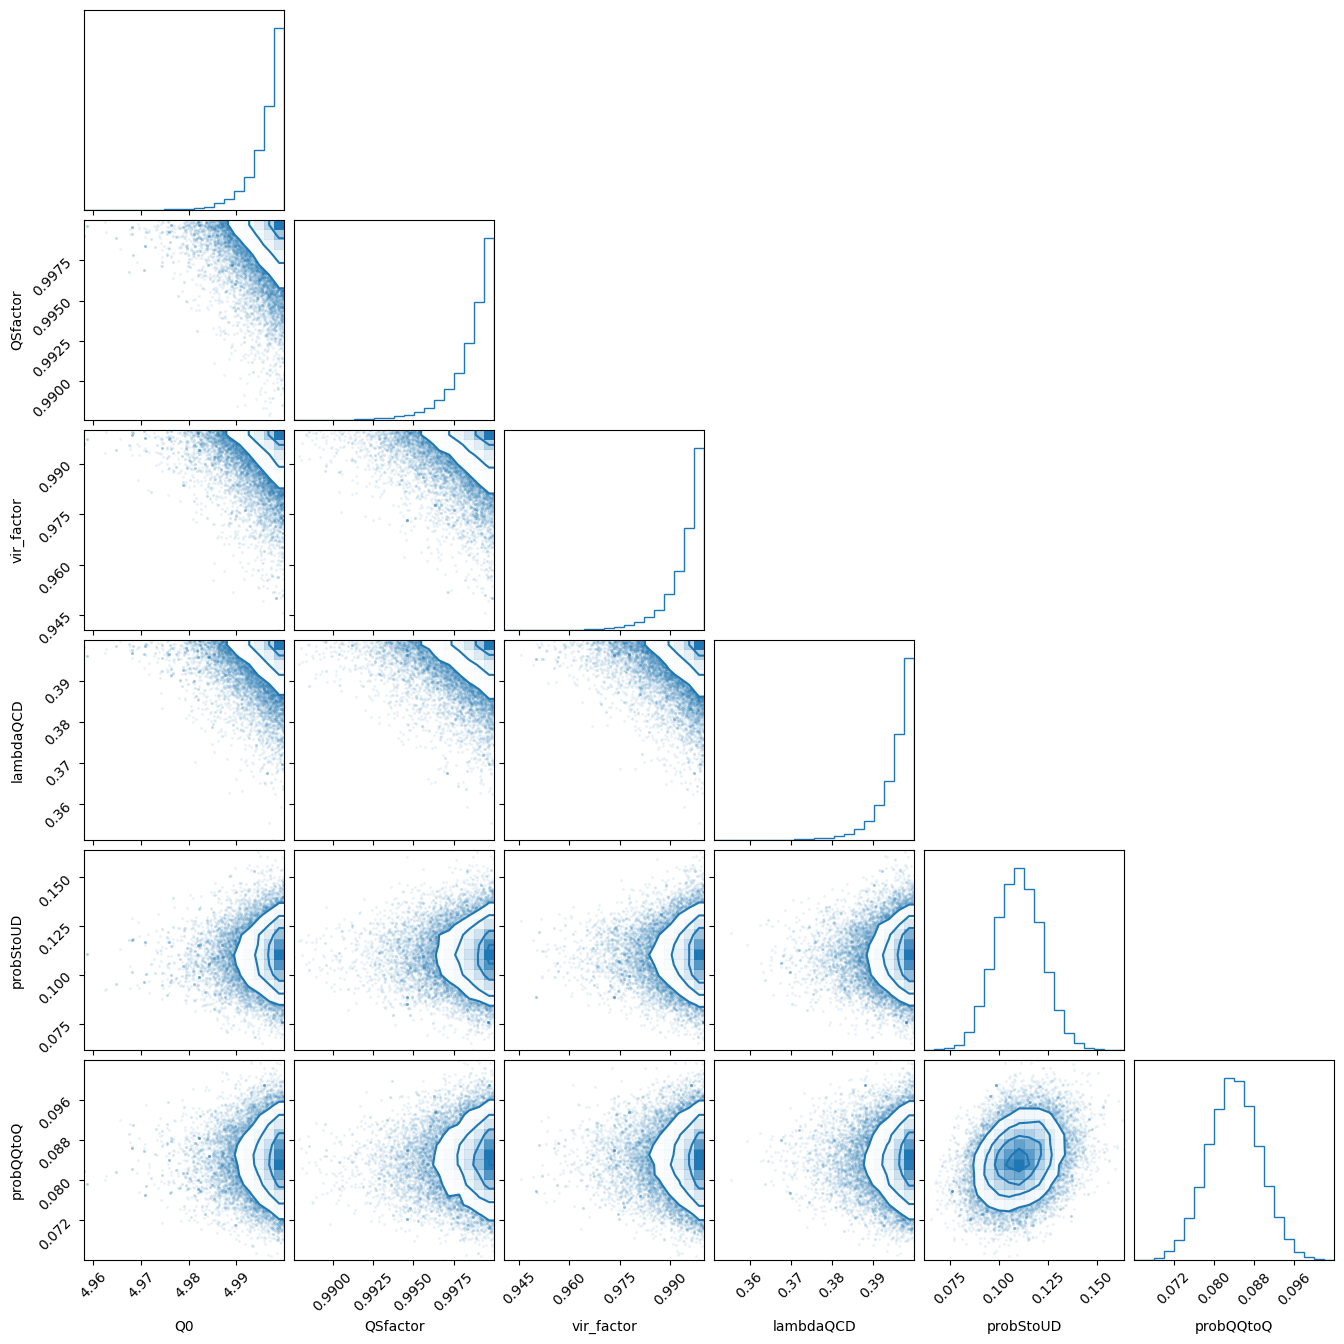

In [ ]:
import pickle
import corner
import matplotlib.pyplot as plt
import numpy as np
        
with open('mcmc/chain.pkl', 'rb') as pf:
        data = pickle.load(pf)

labels = mymcmc.label

fig = corner.corner(data['chain'], weights=data['weights'], labels=labels, color="C0")
plt.show()

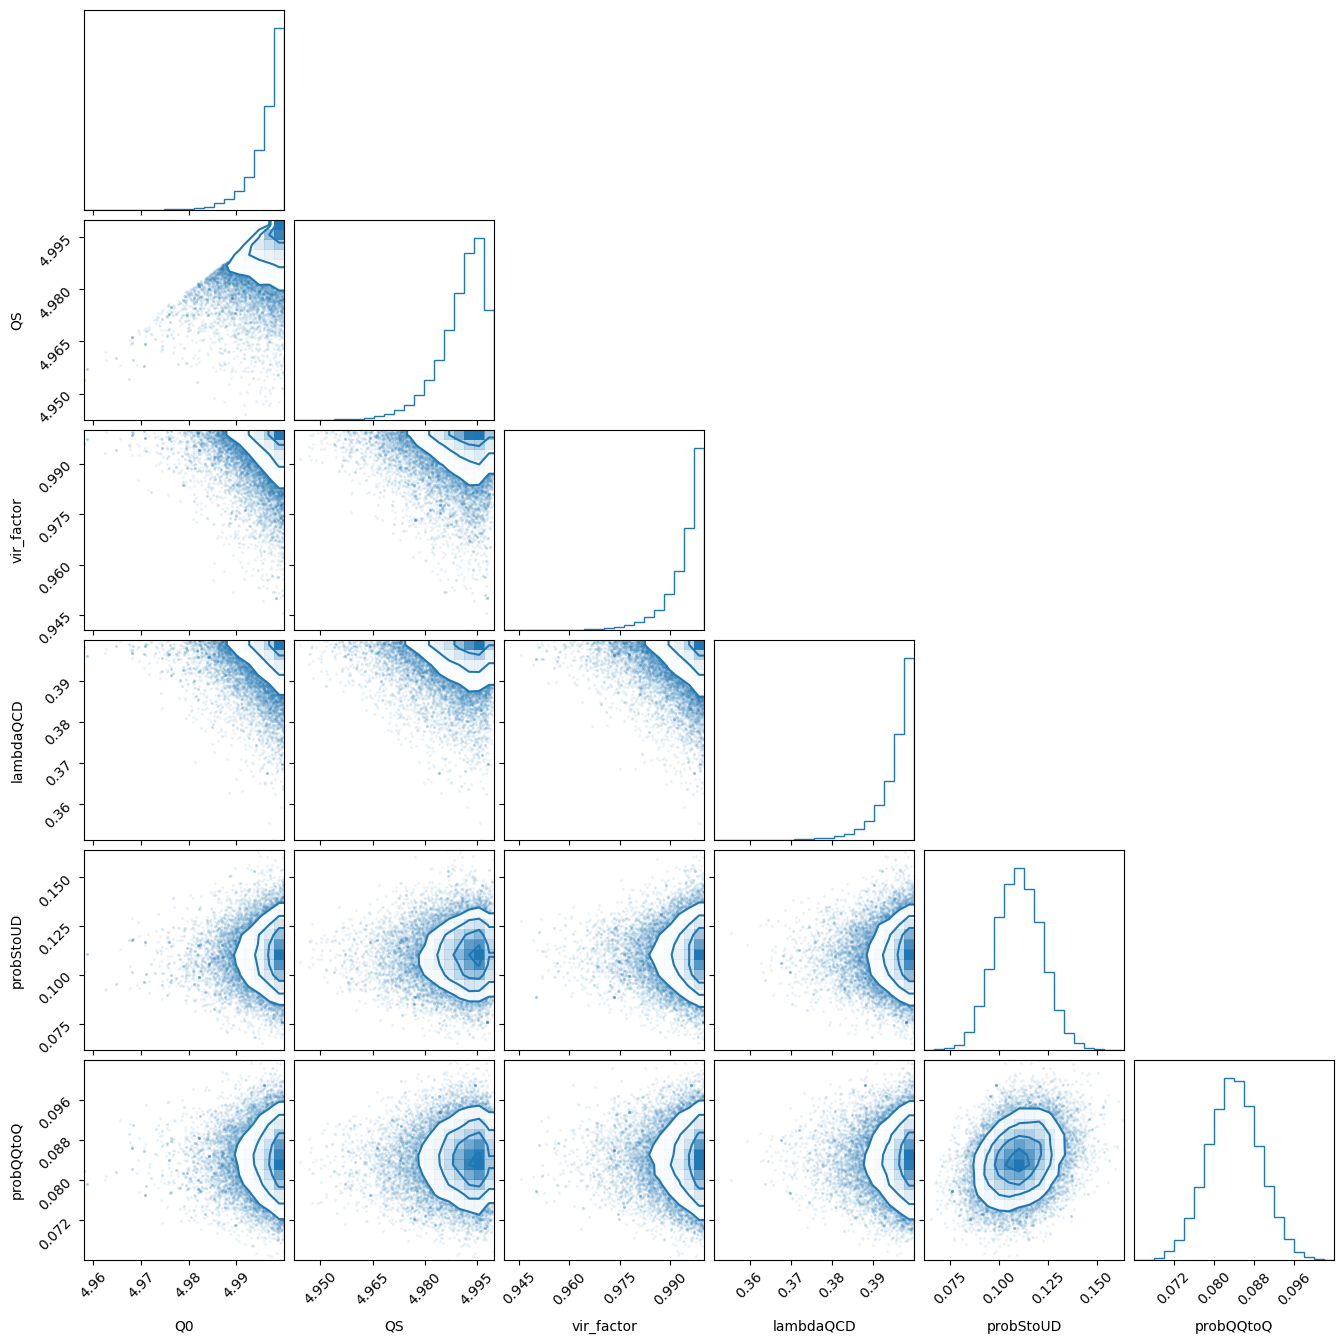

Q0: 4.997-0.009+0.003
QS: 4.992-0.016+0.007
vir_factor: 0.996-0.015+0.004
lambdaQCD: 0.397-0.011+0.003
probStoUD: 0.110-0.020+0.020
probQQtoQ: 0.084-0.009+0.009


In [ ]:
TransformedSamples = np.copy(data['chain'])
TransformedSamples[:,0] = data['chain'][:,0]
TransformedSamples[:,1] = (2*data['chain'][:,3]+0.05) + (data['chain'][:,0]-(2*data['chain'][:,3]+0.05))*data['chain'][:,1]
TransformedSamples[:,2] = data['chain'][:,2]
TransformedSamples[:,3] = data['chain'][:,3]
TransformedSamples[:,4] = data['chain'][:,4]
TransformedSamples[:,5] = data['chain'][:,5]

labels[1] = "QS"
fig = corner.corner(TransformedSamples, weights=data['weights'], labels=labels, color="C0")
plt.show()

bestParams = extract_parameters(TransformedSamples, labels, "/data/rjfgroup/rjf01/cameron.parker/tunes/epem/")

Priors

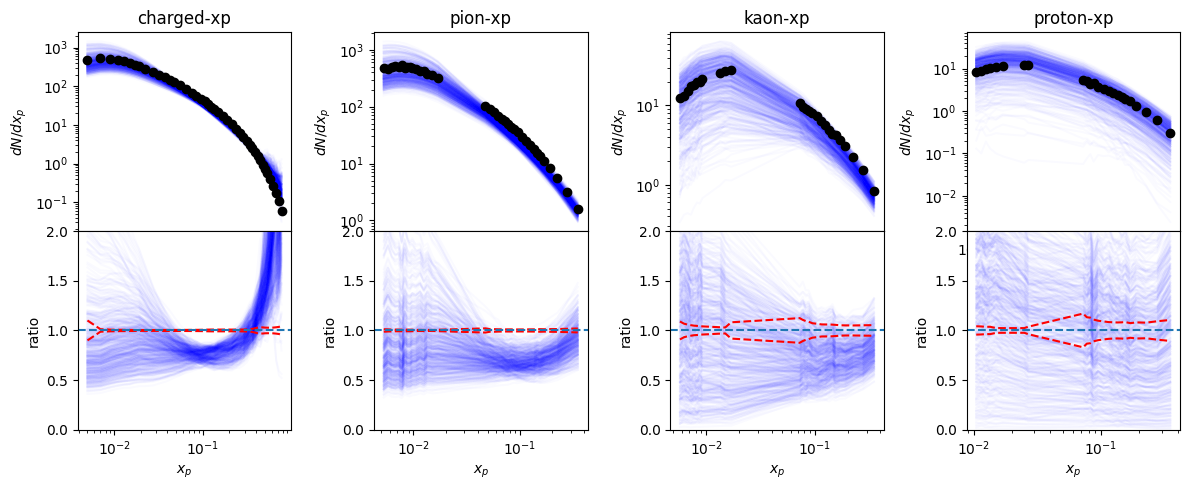

In [ ]:
makeplot(ThisData, "Priors", "/data/rjfgroup/rjf01/cameron.parker/tunes/epem/")

Posteriors

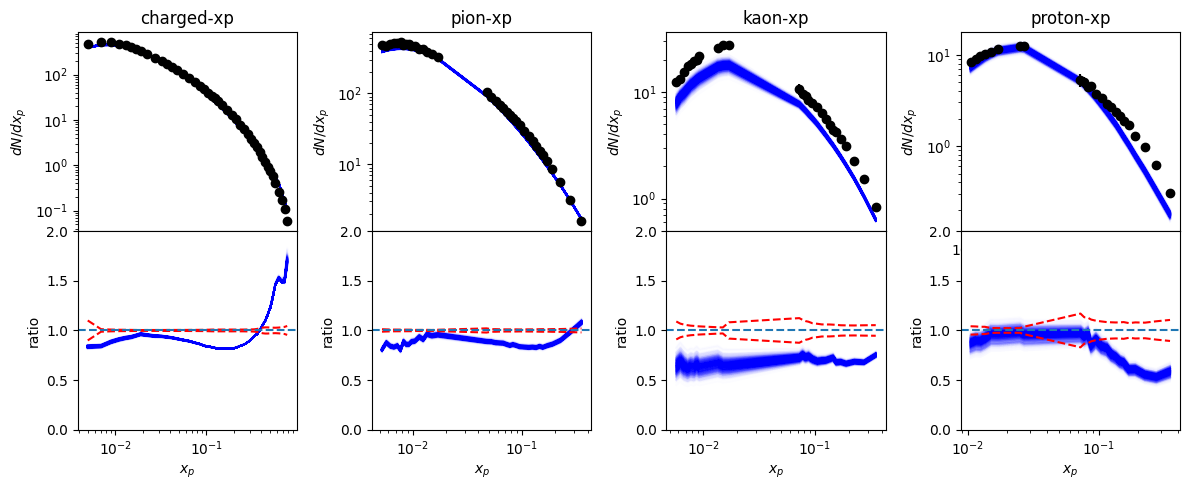

In [ ]:
makeplot(ThisData, "Posteriors", "/data/rjfgroup/rjf01/cameron.parker/tunes/epem/", samples=data["chain"])